In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import glob
import math
import os
import random

In [3]:
# Loading images
img_2000 = cv2.imread("./inputs/P3/lake_urmia_2000.jpg")
img_2018 = cv2.imread("./inputs/P3/lake_urmia_2018.jpg")
img_2020 = cv2.imread("./inputs/P3/lake_urmia_2020.jpg")

In [4]:
def WaterMaskExtractor(img,coef_=0.085):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # noise removal
    kernel = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 8)
    
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations = 12)
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    _, sure_fg = cv2.threshold(dist_transform,coef_*dist_transform.max(),255,0)
    
    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)

    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers+1
    
    # mark the region of unknown with 0
    markers[unknown==255] = 0
    
    markers = cv2.watershed(img,markers)
    
    return markers


marker_2000 = WaterMaskExtractor(img_2000,0.15)
marker_2018 = WaterMaskExtractor(img_2018,0.7)
marker_2020 = WaterMaskExtractor(img_2020,0.2)

In [5]:
# Generating visual result for 2000
crop_2000 = img_2000.copy()
crop_2000[marker_2000==1]=(0,0,0)
region_2000 = crop_2000.copy()
index = np.logical_or(marker_2000==2 , marker_2000==3)
pix_2000 = np.mean(region_2000[index],axis=0)
region_2000[index] = (150,50,50)
water_2000 = region_2000.copy()
water_2000[index] = (255,255,255)

# Generating visual result for 2020
crop_2020 = img_2020.copy()
crop_2020[marker_2000==1]=(0,0,0)
region_2020 = crop_2020.copy()
index = np.logical_or(marker_2020==2 , marker_2020==3)
pix_2020 = np.mean(region_2020[index],axis=0)
region_2020[index] = (150,50,50)
water_2020 = cv2.inRange(crop_2020,pix_2020-35,pix_2020+20)


# Generating visual result for 2018
crop_2018 = img_2018.copy()
crop_2018[marker_2000==1]=(0,0,0)
region_2018 = crop_2018.copy()
index = np.logical_or(marker_2018==2 , marker_2018==3)
pix_2018 = np.mean(region_2018[index],axis=0)
region_2018[index] = (150,50,50)
water_2018 = cv2.inRange(crop_2018,pix_2018-25,pix_2018+5)


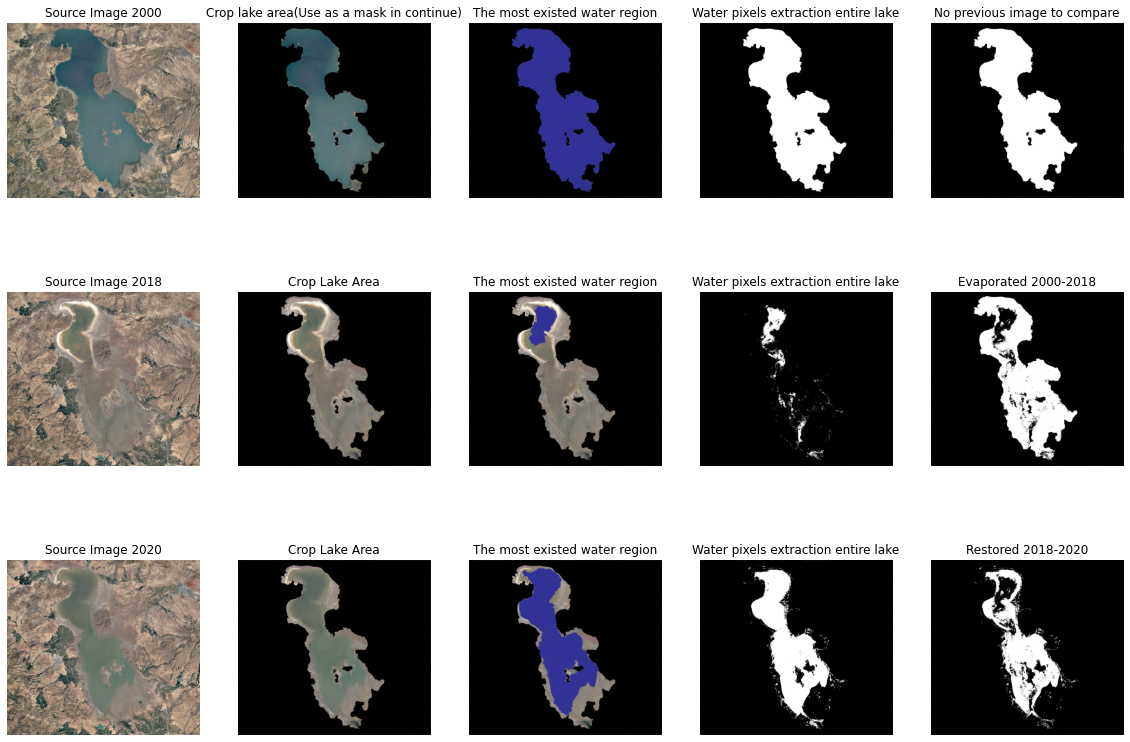

In [6]:
plt.rcParams["figure.figsize"] = (20,14)

plt.subplot(3,5,1)
plt.imshow(cv2.cvtColor(img_2000,cv2.COLOR_BGR2RGB))
plt.title("Source Image 2000")
plt.axis("off")

plt.subplot(3,5,2)
plt.imshow(cv2.cvtColor(crop_2000,cv2.COLOR_BGR2RGB))
plt.title("Crop lake area(Use as a mask in continue)")
plt.axis("off")

plt.subplot(3,5,3)
plt.imshow(cv2.cvtColor(region_2000,cv2.COLOR_BGR2RGB))
plt.title("The most existed water region")
plt.axis("off")

plt.subplot(3,5,4)
plt.imshow(cv2.cvtColor(water_2000,cv2.COLOR_BGR2RGB))
plt.title("Water pixels extraction entire lake")
plt.axis("off")

plt.subplot(3,5,5)
plt.imshow(cv2.cvtColor(water_2000,cv2.COLOR_BGR2RGB))
plt.title("No previous image to compare")
plt.axis("off")

plt.subplot(3,5,6)
plt.imshow(cv2.cvtColor(img_2018,cv2.COLOR_BGR2RGB))
plt.title("Source Image 2018")
plt.axis("off")

plt.subplot(3,5,7)
plt.imshow(cv2.cvtColor(crop_2018,cv2.COLOR_BGR2RGB))
plt.title("Crop Lake Area")
plt.axis("off")

plt.subplot(3,5,8)
plt.imshow(cv2.cvtColor(region_2018,cv2.COLOR_BGR2RGB))
plt.title("The most existed water region")
plt.axis("off")

plt.subplot(3,5,9)
plt.imshow(cv2.cvtColor(water_2018,cv2.COLOR_BGR2RGB))
plt.title("Water pixels extraction entire lake")
plt.axis("off")

plt.subplot(3,5,10)
plt.imshow(cv2.cvtColor(water_2000[:,:,0]-water_2018,cv2.COLOR_BGR2RGB))
plt.title("Evaporated 2000-2018")
plt.axis("off")

plt.subplot(3,5,11)
plt.imshow(cv2.cvtColor(img_2020,cv2.COLOR_BGR2RGB))
plt.title("Source Image 2020")
plt.axis("off")

plt.subplot(3,5,12)
plt.imshow(cv2.cvtColor(crop_2020,cv2.COLOR_BGR2RGB))
plt.title("Crop Lake Area")
plt.axis("off")

plt.subplot(3,5,13)
plt.imshow(cv2.cvtColor(region_2020,cv2.COLOR_BGR2RGB))
plt.title("The most existed water region")
plt.axis("off")

plt.subplot(3,5,14)
plt.imshow(cv2.cvtColor(water_2020,cv2.COLOR_BGR2RGB))
plt.title("Water pixels extraction entire lake")
plt.axis("off")

plt.subplot(3,5,15)
plt.imshow(cv2.cvtColor(water_2020-water_2018,cv2.COLOR_BGR2RGB))
plt.title("Restored 2018-2020")

plt.axis("off")
plt.show()

In [7]:

# water pixels counting in 2000
_gray_scale = cv2.cvtColor(region_2000,cv2.COLOR_BGR2GRAY)
_, _2000_water_count = cv2.threshold(_gray_scale,0,255,cv2.THRESH_BINARY)
print(_2000_water_count.shape)
_2000_water_count = _2000_water_count.flatten().sum()//255

# water pixels counting in 2018
print(water_2018.shape)
_2018_water_count = water_2018.flatten().sum()//255

# water pixels counting in 2020
print(water_2020.shape)
_2020_water_count = water_2020.flatten().sum()//255

(2360, 2600)
(2360, 2600)
(2360, 2600)


In [8]:
area_in_meter = (20000/314)**2
vol_2000 = _2000_water_count*area_in_meter*(2.8)
vol_2018 = _2018_water_count*area_in_meter*(0.6)
vol_2020 = _2020_water_count*area_in_meter*(0.9)
print("Vol of Evaporated from 2000 to 2018:",vol_2000-vol_2018)

Vol of Evaporated from 2000 to 2018: 14756634346.22094


In [12]:
print("Percentage of water existed in 2018 to 2000:",round(vol_2018/vol_2000*100,3),"%")
print("Percentage of water existed in 2020 to 2000:",round(vol_2020/vol_2000*100,3),"%")

Percentage of water existed in 2018 to 2000: 2.434 %
Percentage of water existed in 2020 to 2000: 20.433 %
